In [1]:
from pathlib import Path

# 1. Trouve dynamiquement la racine du projet (contenant .gitignore)
cwd = Path.cwd()
PROJECT_ROOT = next(p for p in (cwd, *cwd.parents) if (p / ".gitignore").exists())

print("PROJECT_ROOT =", PROJECT_ROOT)

PROJECT_ROOT = /Users/mackjb/repository/datasciencetest_reco_plante


In [20]:
from pathlib import Path
import pandas as pd
import plotly.express as px
import os
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import DBSCAN
from skimage.feature.texture import graycomatrix as greycomatrix, graycoprops as greycoprops


In [13]:
def black_components_above_size(img_path, threshold=10, min_component_size=200):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    _, mask_black = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY_INV)
    nb_components, labels, stats, _ = cv2.connectedComponentsWithStats(mask_black)
    sizes = stats[1:, cv2.CC_STAT_AREA]  # ignorer le fond (composant 0)
    large_components = [s for s in sizes if s >= min_component_size]
    nb_large_components = len(large_components)
    
    # Filtrer le masque pour ne garder que les composants > taille seuil
    filtered_mask = np.zeros_like(mask_black)
    for i, size in enumerate(sizes, start=1):
        if size >= min_component_size:
            filtered_mask[labels == i] = 255
    return nb_large_components

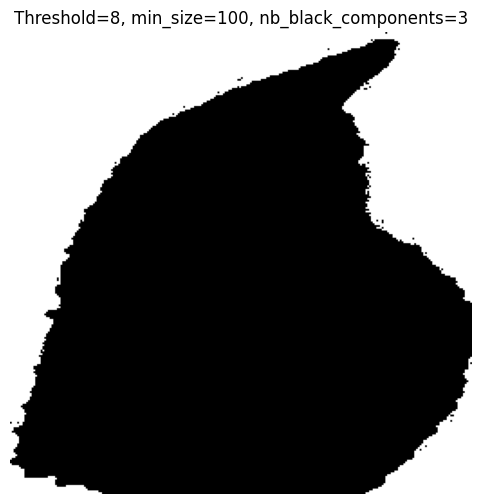

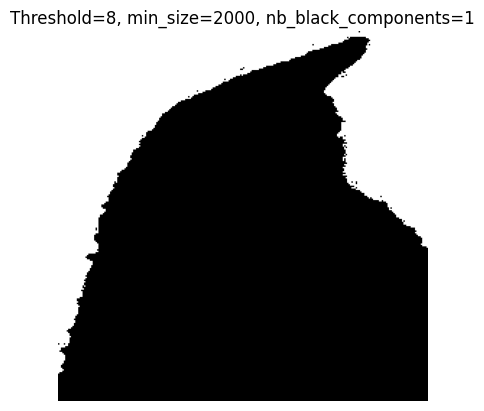

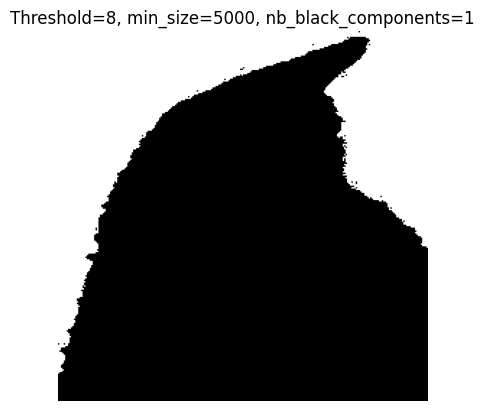

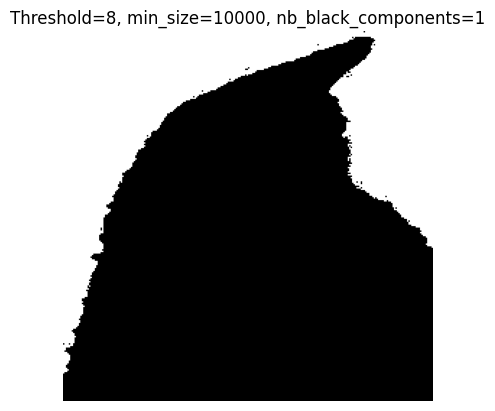

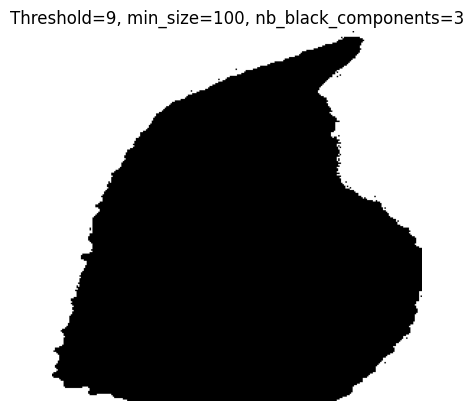

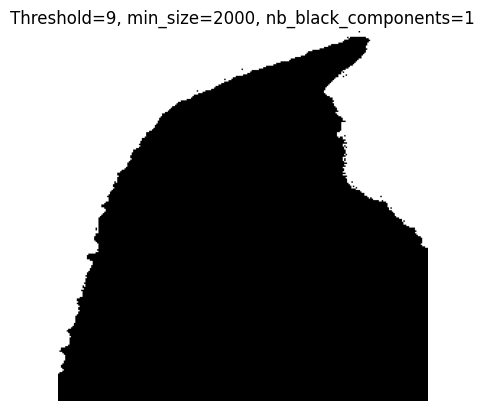

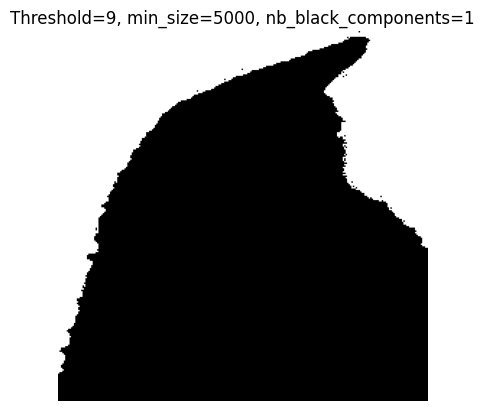

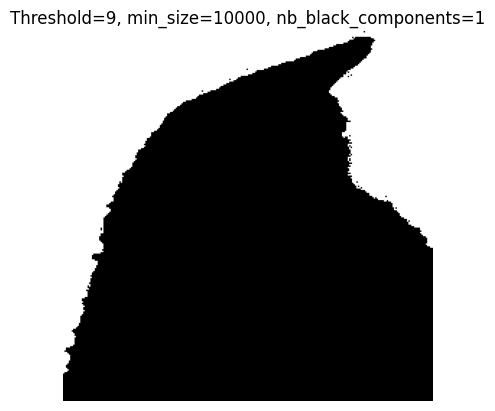

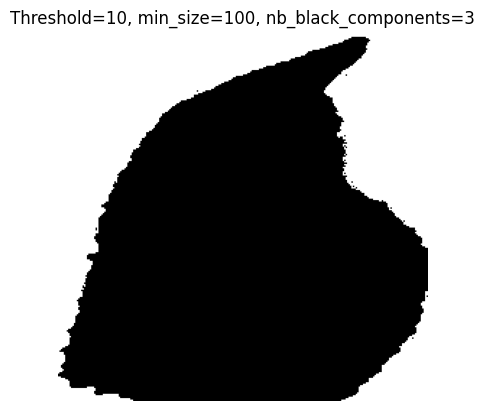

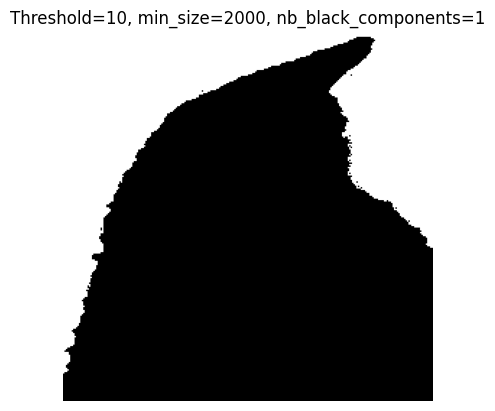

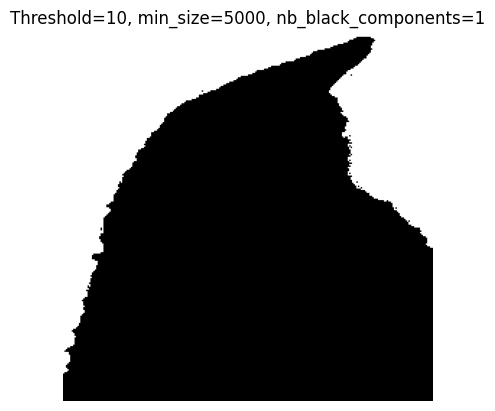

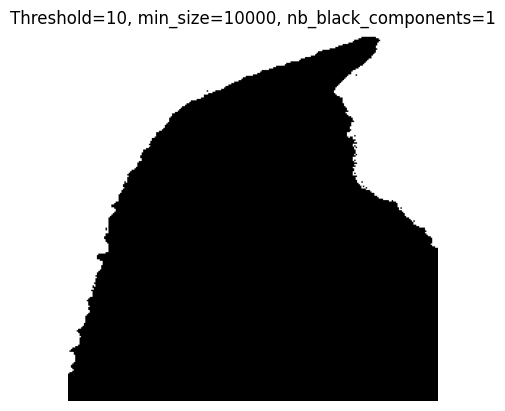

In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def black_components_above_size(img_path, threshold, min_component_size):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    _, mask_black = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY_INV)
    nb_components, labels, stats, _ = cv2.connectedComponentsWithStats(mask_black)
    sizes = stats[1:, cv2.CC_STAT_AREA]  # ignorer le fond (composant 0)
    large_components = [s for s in sizes if s >= min_component_size]
    nb_large_components = len(large_components)
    
    # Filtrer le masque pour ne garder que les composants > taille seuil
    filtered_mask = np.zeros_like(mask_black)
    for i, size in enumerate(sizes, start=1):
        if size >= min_component_size:
            filtered_mask[labels == i] = 255
    return nb_large_components, filtered_mask

# img_path = "/Users/mackjb/repository/datasciencetest_reco_plante/dataset/plantvillage/data/plantvillage_5images/segmented/Apple___Apple_scab/01f3deaa-6143-4b6c-9c22-620a46d8be04___FREC_Scab 3112_final_masked.jpg"
img_path = "/Users/mackjb/repository/datasciencetest_reco_plante/dataset/plantvillage/data/plantvillage_5images/segmented/Apple___Apple_scab/01a66316-0e98-4d3b-a56f-d78752cd043f___FREC_Scab 3003_final_masked.jpg"


min_sizes = [100, 2000, 5000, 10000]

plt.figure(figsize=(10, 6))

for threshold in range(
    8, 11):
    for min_size in min_sizes:
        nb_components, filtered_mask = black_components_above_size(img_path, threshold, min_size)
        plt.imshow(filtered_mask, cmap='gray')
        plt.title(f"Threshold={threshold}, min_size={min_size}, nb_black_components={nb_components}")
        plt.axis('off')
        plt.show()
        input("Appuie sur Enter pour continuer...")
        
        
        
        
        

In [5]:
import numpy as np
from PIL import Image

# Après avoir binaire l’image (seuillage) segmented, il suffit de regarder si des pixels “feuille” sont présents sur les bords (haut, bas, gauche, droite).
def touches_border(img_path, threshold=15):
    img = Image.open(img_path).convert('L')
    arr = np.array(img)
    mask = arr > threshold  # Pixels de la feuille (fond noir = 0)
    h, w = mask.shape

    touches = {
        'top': mask[0, :].any(),
        'bottom': mask[-1, :].any(),
        'left': mask[:, 0].any(),
        'right': mask[:, -1].any()
    }
    return any(touches.values()), touches



In [ ]:
# root_dir déjà défini
# root_dir = PROJECT_ROOT/"dataset"/"plantvillage"/"data"/"plantvillage_5images"/"segmented"
root_dir = PROJECT_ROOT/"dataset"/"plantvillage"/"data"/"plantvillage dataset"/"segmented"



data = []
for subdir, dirs, files in os.walk(root_dir):
    for file in files:
        if not file.lower().endswith(('.jpg','.jpeg','.png')):
            continue

        filepath = os.path.join(subdir, file)
        rel_path = os.path.relpath(filepath, root_dir)
        parts = rel_path.split(os.sep)
        # extraction class/disease
        if len(parts)>=2 and "___" in parts[0]:
            plant_class, disease = parts[0].split('___',1)
        elif len(parts)>=3:
            plant_class, disease = parts[0], parts[1]
        else:
            plant_class, disease = parts[0], None
        ext = os.path.splitext(file)[1].lower().lstrip('.')

        # init
        width = height = None
        area = peri = asp_ratio = extent = solidity = 0
        mean_col = [None, None, None]
        std_col  = [None, None, None]
        contrast = homogeneity = energy = correlation = None

        try:
            img_pil = Image.open(filepath).convert('RGB')
            width, height = img_pil.size
            arr = np.array(img_pil)
            gray = cv2.cvtColor(arr, cv2.COLOR_RGB2GRAY)

            # -> Forme
            # Binarisation : seuil pour isoler la lésion  
            # → convertit en image binaire où tout pixel >10 devient blanc (255)  
            _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

            # Détection des contours externes  
            # → récupère toutes les formes blanches, on choisit la plus grosse (la lésion)  
            cnts, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if cnts:
                cnt = max(cnts, key=cv2.contourArea)

                # 1) Forme géométrique
                area = cv2.contourArea(cnt)
                #   • area : surface de la lésion (nombre de pixels) → taille infectée
                peri = cv2.arcLength(cnt, True)
                #   • peri : longueur du contour → complexité/irrégularité du bord

                x, y, w, h = cv2.boundingRect(cnt)
                asp_ratio = w/h if h>0 else 0
                #   • asp_ratio (rapport w/h) : différencie formes allongées vs rondes
                extent = area/(w*h) if w*h>0 else 0
                #   • extent : compacité par rapport au rectangle englobant

                hull = cv2.convexHull(cnt)
                solidity = area/cv2.contourArea(hull) if cv2.contourArea(hull)>0 else 0
                #   • solidity : proportion surface/convex hull → quantifie les indentations
            else:
                # pas de contour détecté → valeurs nulles
                area = peri = asp_ratio = extent = solidity = 0

            # 2) Couleur globale
            # → moyenne et écart-type par canal RGB pour capturer la teinte dominante et le contraste chromatique
            mean_col = arr.mean(axis=(0,1)).tolist()    # [mean_R, mean_G, mean_B]
            std_col  = arr.std(axis=(0,1)).tolist()     # [std_R,  std_G,  std_B]

            # 3) Texture (GLCM : Grey Level Co-occurrence Matrix)
            # → quantifie motifs et rugosité
            glcm = greycomatrix(
                gray,
                distances=[1],       # pixel adjacent
                angles=[0],          # horizontal
                levels=256,
                symmetric=True,
                normed=True
            )
            contrast    = greycoprops(glcm, 'contrast')[0,0]
            #   • contrast : intensité des variations → granulosité
            homogeneity = greycoprops(glcm, 'homogeneity')[0,0]
            #   • homogeneity : uniformité → présence de zones régulières
            energy      = greycoprops(glcm, 'energy')[0,0]
            #   • energy : ordre des motifs → degré de répétitivité
            correlation = greycoprops(glcm, 'correlation')[0,0]
            #   • correlation : similarité spatiale → structure et alignement des textures

        except Exception as e:
            # en cas d’erreur de lecture ou calcul on garde les valeurs par défaut
            print(f"Erreur GLCM sur {filepath}:", e)
            pass

        data.append({
            "filepath": filepath,
            "filename": file,
            "class": plant_class,
            "disease": disease,
            "extension": ext,
            "width": width,
            "height": height,
            "touches_border": touches_border(filepath),             # si la lésion touche le bord
            "result": black_components_above_size(filepath, 2000, 10),
            # géométrie
            "area": area,
            "perimeter": peri,
            "aspect_ratio": asp_ratio,
            "extent": extent,
            "solidity": solidity,
            # couleur
            "mean_R": mean_col[0], "mean_G": mean_col[1], "mean_B": mean_col[2],
            "std_R":  std_col[0],  "std_G":  std_col[1],  "std_B":  std_col[2],
            # texture
            "glcm_contrast":    contrast,
            "glcm_homogeneity": homogeneity,
            "glcm_energy":      energy,
            "glcm_correlation": correlation
        })

pd.set_option('display.max_colwidth', None)
df = pd.DataFrame(data)
df_sorted = df.sort_values(by="filepath").reset_index(drop=True)
df_sorted.head()

,filepath,filename,class,disease,extension,width,height,touches_border,result,area,...,mean_R,mean_G,mean_B,std_R,std_G,std_B,glcm_contrast,glcm_homogeneity,glcm_energy,glcm_correlation
0,/Users/mackjb/repository/datasciencetest_reco_plante/dataset/plantvillage/data/plantvillage_5images/segmented/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335_final_masked.jpg,00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335_final_masked.jpg,Apple,Apple_scab,jpg,256,256,"(True, {'top': False, 'bottom': True, 'left': False, 'right': False})",1,40593.0,...,53.085205,86.403412,41.695847,52.372885,74.049660,47.926646,102.918290,0.477993,0.293757,0.987340
1,/Users/mackjb/repository/datasciencetest_reco_plante/dataset/plantvillage/data/plantvillage_5images/segmented/Apple___Apple_scab/01a66316-0e98-4d3b-a56f-d78752cd043f___FREC_Scab 3003_final_masked.jpg,01a66316-0e98-4d3b-a56f-d78752cd043f___FREC_Scab 3003_final_masked.jpg,Apple,Apple_scab,jpg,256,256,"(True, {'top': False, 'bottom': True, 'left': True, 'right': True})",1,42873.0,...,47.960831,73.061142,26.245575,42.646975,58.386195,32.398824,96.383195,0.452061,0.271672,0.980587
2,/Users/mackjb/repository/datasciencetest_reco_plante/dataset/plantvillage/data/plantvillage_5images/segmented/Apple___Apple_scab/01f3deaa-6143-4b6c-9c22-620a46d8be04___FREC_Scab 3112_final_masked.jpg,01f3deaa-6143-4b6c-9c22-620a46d8be04___FREC_Scab 3112_final_masked.jpg,Apple,Apple_scab,jpg,256,256,"(True, {'top': False, 'bottom': True, 'left': True, 'right': False})",1,49505.5,...,49.182251,78.532639,30.835709,43.739286,53.706312,33.389855,146.802451,0.331925,0.173383,0.967598
3,/Users/mackjb/repository/datasciencetest_reco_plante/dataset/plantvillage/data/plantvillage_5images/segmented/Apple___Apple_scab/0208f4eb-45a4-4399-904e-989ac2c6257c___FREC_Scab 3037_final_masked.jpg,0208f4eb-45a4-4399-904e-989ac2c6257c___FREC_Scab 3037_final_masked.jpg,Apple,Apple_scab,jpg,256,256,"(True, {'top': False, 'bottom': True, 'left': False, 'right': False})",1,33935.5,...,57.691238,62.244995,34.445663,57.757675,63.002505,36.305277,130.593765,0.497418,0.407910,0.980711
4,/Users/mackjb/repository/datasciencetest_reco_plante/dataset/plantvillage/data/plantvillage_5images/segmented/Apple___Apple_scab/023123cb-7b69-4c9f-a521-766d7c8543bb___FREC_Scab 3487_final_masked.jpg,023123cb-7b69-4c9f-a521-766d7c8543bb___FREC_Scab 3487_final_masked.jpg,Apple,Apple_scab,jpg,256,256,"(True, {'top': False, 'bottom': True, 'left': True, 'right': False})",1,44173.5,...,53.350998,76.791733,43.789734,41.900235,56.617749,36.606669,91.865227,0.450584,0.262930,0.981319


In [ ]:

# # Chemin vers le dossier principal PlantVillage
# # root_dir = PROJECT_ROOT / "dataset" / "plantvillage" / "data" / "plantvillage dataset" / "segmented"
# root_dir = PROJECT_ROOT / "dataset" / "plantvillage" / "data" / "plantvillage_5images" / "segmented"



# data = []

# for subdir, dirs, files in os.walk(root_dir):
#     for file in files:
#         if file.lower().endswith(('.jpg', '.jpeg', '.png')):
#             filepath = os.path.join(subdir, file)
#             rel_path = os.path.relpath(filepath, root_dir)
#             parts = rel_path.split(os.sep)

#             # Cas 1 : PlantVillage/Strawberry___healthy/image.jpg
#             if len(parts) >= 2 and "___" in parts[0]:
#                 # format: class___disease/filename
#                 class_disease = parts[0]
#                 plant_class, disease = class_disease.split('___', 1)
#             # Cas 2 : PlantVillage/Strawberry/healthy/image.jpg
#             elif len(parts) >= 3:
#                 plant_class, disease = parts[0], parts[1]
#             # Cas fallback
#             else:
#                 plant_class, disease = parts[0], None

#             ext = os.path.splitext(file)[-1].lower().replace('.', '')

#             try:
#                 with Image.open(filepath) as img:
#                     width, height = img.size
#                     # Optionnel : is_centered (pas modifié ici)
#             except Exception as e:
#                 width, height = None, None

#             data.append({
#                 "filepath": filepath,
#                 "filename": file,
#                 "class": plant_class,
#                 "disease": disease,
#                 "extension": ext,
#                 "width": width,
#                 "height": height,
#                 "touches_border": touches_border(filepath),
#                 "result": black_components_above_size(img_path=filepath, min_component_size=2000, threshold=10)
#             })
# pd.set_option('display.max_colwidth', None)
# df = pd.DataFrame(data)
# # df.head(1)

# df_sorted = df.sort_values(by="filepath", ascending=True)
# df_sorted.head()


,filepath,filename,class,disease,extension,width,height,touches_border,result
127,/Users/mackjb/repository/datasciencetest_reco_plante/dataset/plantvillage/data/plantvillage_5images/segmented/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335_final_masked.jpg,00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335_final_masked.jpg,Apple,Apple_scab,jpg,256,256,"(True, {'top': False, 'bottom': True, 'left': False, 'right': False})",1
126,/Users/mackjb/repository/datasciencetest_reco_plante/dataset/plantvillage/data/plantvillage_5images/segmented/Apple___Apple_scab/01a66316-0e98-4d3b-a56f-d78752cd043f___FREC_Scab 3003_final_masked.jpg,01a66316-0e98-4d3b-a56f-d78752cd043f___FREC_Scab 3003_final_masked.jpg,Apple,Apple_scab,jpg,256,256,"(True, {'top': False, 'bottom': True, 'left': True, 'right': True})",1
129,/Users/mackjb/repository/datasciencetest_reco_plante/dataset/plantvillage/data/plantvillage_5images/segmented/Apple___Apple_scab/01f3deaa-6143-4b6c-9c22-620a46d8be04___FREC_Scab 3112_final_masked.jpg,01f3deaa-6143-4b6c-9c22-620a46d8be04___FREC_Scab 3112_final_masked.jpg,Apple,Apple_scab,jpg,256,256,"(True, {'top': False, 'bottom': True, 'left': True, 'right': False})",1
125,/Users/mackjb/repository/datasciencetest_reco_plante/dataset/plantvillage/data/plantvillage_5images/segmented/Apple___Apple_scab/0208f4eb-45a4-4399-904e-989ac2c6257c___FREC_Scab 3037_final_masked.jpg,0208f4eb-45a4-4399-904e-989ac2c6257c___FREC_Scab 3037_final_masked.jpg,Apple,Apple_scab,jpg,256,256,"(True, {'top': False, 'bottom': True, 'left': False, 'right': False})",1
128,/Users/mackjb/repository/datasciencetest_reco_plante/dataset/plantvillage/data/plantvillage_5images/segmented/Apple___Apple_scab/023123cb-7b69-4c9f-a521-766d7c8543bb___FREC_Scab 3487_final_masked.jpg,023123cb-7b69-4c9f-a521-766d7c8543bb___FREC_Scab 3487_final_masked.jpg,Apple,Apple_scab,jpg,256,256,"(True, {'top': False, 'bottom': True, 'left': True, 'right': False})",2


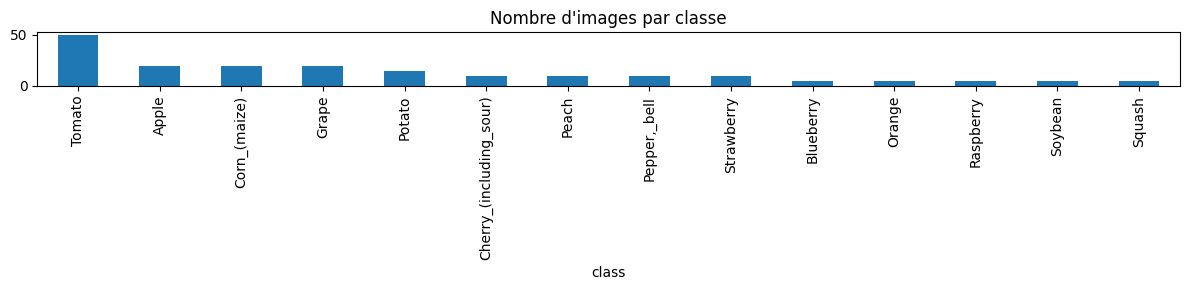

In [8]:
df.groupby("class")["filename"].count().sort_values(ascending=False).plot(kind='bar', figsize=(12,3), title="Nombre d'images par classe")
plt.tight_layout()
plt.show()

/var/folders/49/mc7s19xx4w799f_h_dzrl2kr0000gn/T/ipykernel_80916/1391405169.py:2: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


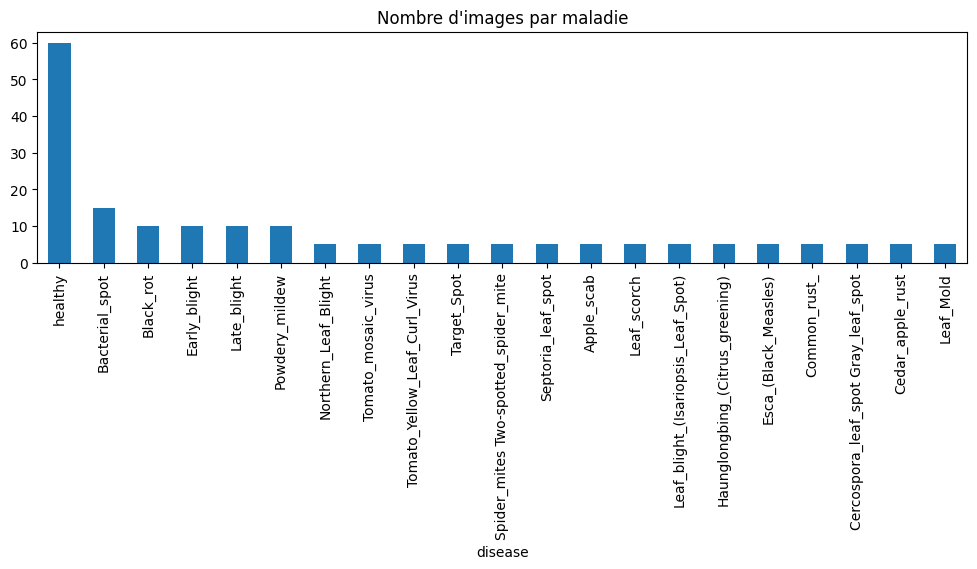

In [9]:
df.groupby("disease")["filename"].count().sort_values(ascending=False).plot(kind='bar', figsize=(12,3), title="Nombre d'images par maladie")
plt.tight_layout()
plt.show()

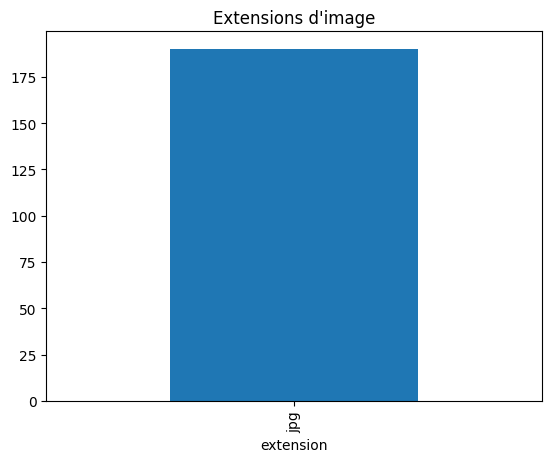

In [10]:
df["extension"].value_counts().plot(kind='bar', title="Extensions d'image")
plt.show()

<Axes: title={'center': 'Résolution des images'}, xlabel='width,height'>

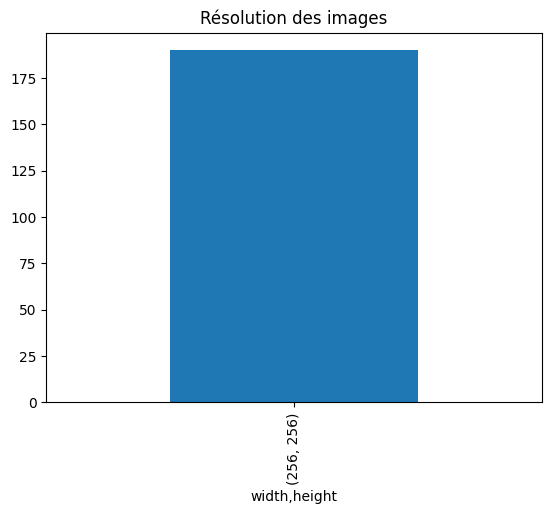

In [11]:
df[["width", "height"]].value_counts().plot(kind='bar', title="Résolution des images")